# imports

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus
from imblearn.over_sampling import SMOTE
import seaborn as sns
from wcbtfidf import Wcbtfidf
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import statsmodels.api as sm



# read school data

In [2]:
brin_csv_path = '/Users/sanam/Desktop/thesis/school_data.csv'
quality_df = pd.read_csv(brin_csv_path) 
quality_df = quality_df[['Brin', 'KwaliteiOnderwijs']]
quality_df = quality_df.drop_duplicates(subset='Brin', keep='first')

print(len(quality_df))
print(quality_df)


1027
      Brin KwaliteiOnderwijs
0     15AI         Voldoende
1     17RK  Geen eindoordeel
2     28MZ  Geen eindoordeel
3     12LT         Voldoende
4     29YP  Geen eindoordeel
...    ...               ...
1177  24EJ  Geen eindoordeel
1178  27TZ       Onvoldoende
1179  13ZB         Voldoende
1180  03ZN  Geen eindoordeel
1181  19UF         Voldoende

[1027 rows x 2 columns]


# Load Data

In [24]:
def load_data(directory, quality_df):
    documents = []
    file_names = []
    brin_values = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            # Remove the ".txt" extension to match with the Brin column in quality_df
            brin_value = filename.replace(".txt", "")
            try:
                quality_rating = quality_df.loc[quality_df['Brin'] == brin_value, 'KwaliteiOnderwijs']
                if quality_rating.empty:
                    continue  # Skip this file
                
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                if not content.strip():  # Check if the content is not just whitespace
                    print(f"Skipping empty file: {filename}")
                    continue  # Skip this file if it's empty
                documents.append(content)
                brin_values.append(brin_value)
                file_names.append(filename)
            except Exception as e:
                print(f"Error reading {filename}: {e}")

        else:
            print("we are here not txt")
    return documents, file_names, brin_values

input_directory = '/Users/sanam/Desktop/thesis/tokPO'

texts, identifiers, brin_values= load_data(input_directory, quality_df)
quality_brin_set = set(quality_df['Brin'])
brin_set = set(brin_values)

missing_brin_values = quality_brin_set - brin_set

quality_df = quality_df[~quality_df['Brin'].isin(missing_brin_values)]
print(len(quality_df))




1012


# TF-IDF


In [4]:

if texts:
    quality_df['KwaliteiOnderwijs'] = quality_df['KwaliteiOnderwijs'].map({
        'Zeer zwak': 3, 'Basistoezicht': 2, 'Onvoldoende': 4, 'Voldoende': 0, 'Goed': 1,'Geen eindoordeel':5
    })
    valid_brin_values = [brin for brin in brin_values if brin in quality_df['Brin'].values]
    quality_ratings = quality_df.set_index('Brin').loc[valid_brin_values, 'KwaliteiOnderwijs'].values
    vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.7)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("Original class distribution:")
    print(pd.Series(quality_ratings).value_counts(ascending= False))

    feature_names = vectorizer.get_feature_names_out()
    index = pd.MultiIndex.from_arrays([range(1, len(brin_values) + 1), brin_values], names=['Row_Number', 'Brin'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=index)
    tfidf_df['Brin'] = brin_values
    updated_csv_path = '/Users/sanam/Desktop/thesis/school_data_with_features.csv'
    tfidf_df.to_csv(updated_csv_path)
    print("CSV file has been updated with TF-IDF features.")

else:
    print("No documents to process.")

    


Original class distribution:
0    428
5    347
4    112
1     78
3     37
2     10
Name: count, dtype: int64
CSV file has been updated with TF-IDF features.


# Plot Data distribution 

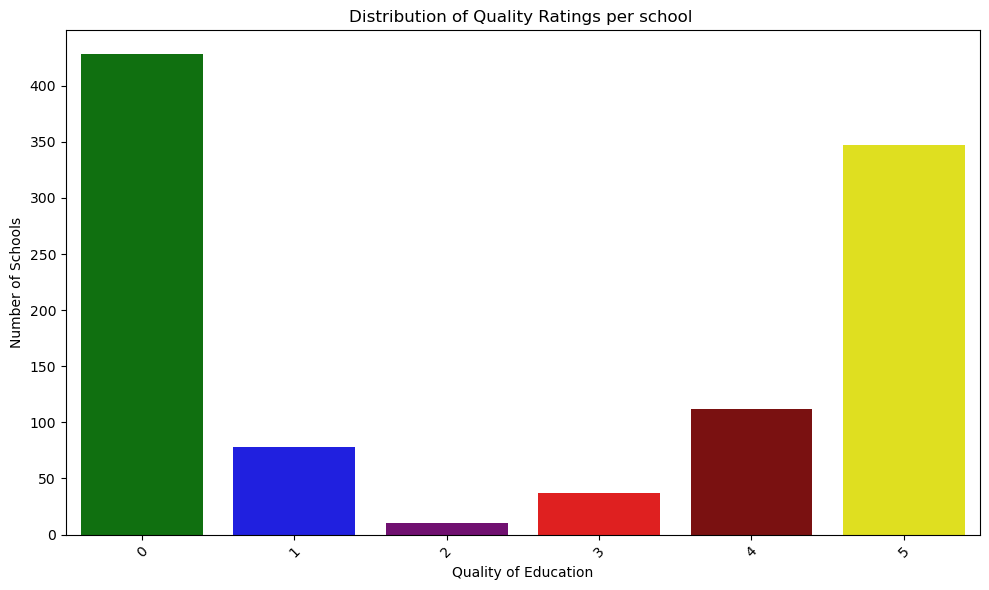

In [5]:
colors = {
    0: 'Green',       # Voldoende
    1: 'Blue',        # Goed
    2: 'Purple',  # Onvoldoende
    3: 'red',
    4: 'darkred',
    5: 'yellow'    # Zeer zwak
}

# Create a custom color map for the plot
color_list = [colors.get(i) for i in range(6)]
plt.figure(figsize=(10, 6))
sns.countplot(x=quality_ratings,palette=color_list)
plt.title('Distribution of Quality Ratings per school ')
plt.xlabel('Quality of Education')
plt.ylabel('Number of Schools')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Coherence score 

In [6]:
def calculate_coherence_score(num_topics, tfidf_matrix, vectorizer, texts):
    nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=600)
    W = nmf_model.fit_transform(tfidf_matrix)
    H = nmf_model.components_

    topics = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in H]

    processed_texts = [text.split() for text in texts]
    
    id2word = Dictionary(processed_texts)
    coherence_model = CoherenceModel(topics=topics, texts=processed_texts, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    return coherence_score

# Find Best number of topics 

Number of Topics: 2, Coherence Score: 0.42777735727988875
Number of Topics: 3, Coherence Score: 0.4849483619259078
Number of Topics: 4, Coherence Score: 0.5973096322947775
Number of Topics: 5, Coherence Score: 0.6247928095252988
Number of Topics: 6, Coherence Score: 0.618528887871942
Number of Topics: 7, Coherence Score: 0.5827169387632191
Number of Topics: 10, Coherence Score: 0.5364040189932081
Number of Topics: 20, Coherence Score: 0.5100226238264621


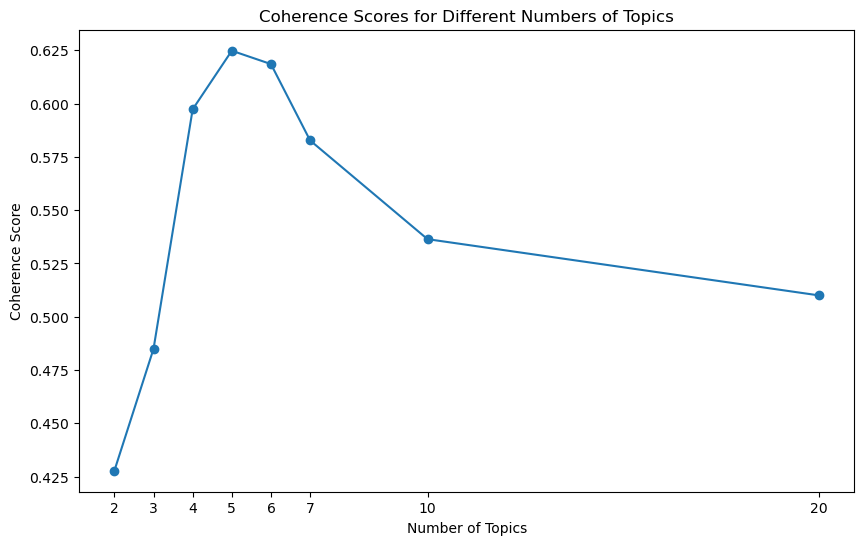

The best number of topics is: 5


In [7]:
num_topics_list = [2, 3, 4, 5, 6,7, 10,20]
coherence_scores = []

for num_topics in num_topics_list:
        coherence_score = calculate_coherence_score(num_topics, tfidf_matrix, vectorizer, texts)
        coherence_scores.append(coherence_score)
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.title('Coherence Scores for Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_list)  # Set the x-axis ticks to match num_topics_list
plt.show()

# Select the number of topics with the highest coherence score
best_num_topics = num_topics_list[np.argmax(coherence_scores)]
print(f"The best number of topics is: {best_num_topics}")

# NMF

In [25]:

num_topics = 5  # You can change the number of topics as needed
nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=600)
W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

# Extract top terms for each topic
feature_names = vectorizer.get_feature_names_out()
topics = [[feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in H]

for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))


assert len(brin_values)== W.shape[0], "Mismatch in length of Brin values and W matrix rows"
assert len(quality_ratings) == W.shape[0], "Mismatch in length of q values and H matrix rows"


topic_df = pd.DataFrame(W, columns=[f'Topic_{i}' for i in range(num_topics)])
topic_df['Brin'] = brin_values
topic_df['KwaliteiOnderwijs'] = quality_ratings


topic_df.to_csv("topicperschoolall.csv", index=False)




Topic 0:
wpo artikel zwak herstelonderzoek herstelopdracht ontbreken ononderbroken schoolgids uiterlijk maatregel
Topic 1:
eindoordeel schoolleiding curriculum toelichting opvolgen samenhangen basisvaardighed beslisregel herstelopdracht beleid
Topic 2:
nederlands uitgangssituatie financieel buitenland schoolleider online principe waarderen klimaat primair
Topic 3:
educatie kleuter samenwerking voorschool gemeente voorschools obs basisschol schoolbestuur basisschool
Topic 4:
basisschool oorde waardering waarderen zelfevaluatie vereist competentie basiskwaliteit maatschappelijk signal


# Plot quality distribution per topic

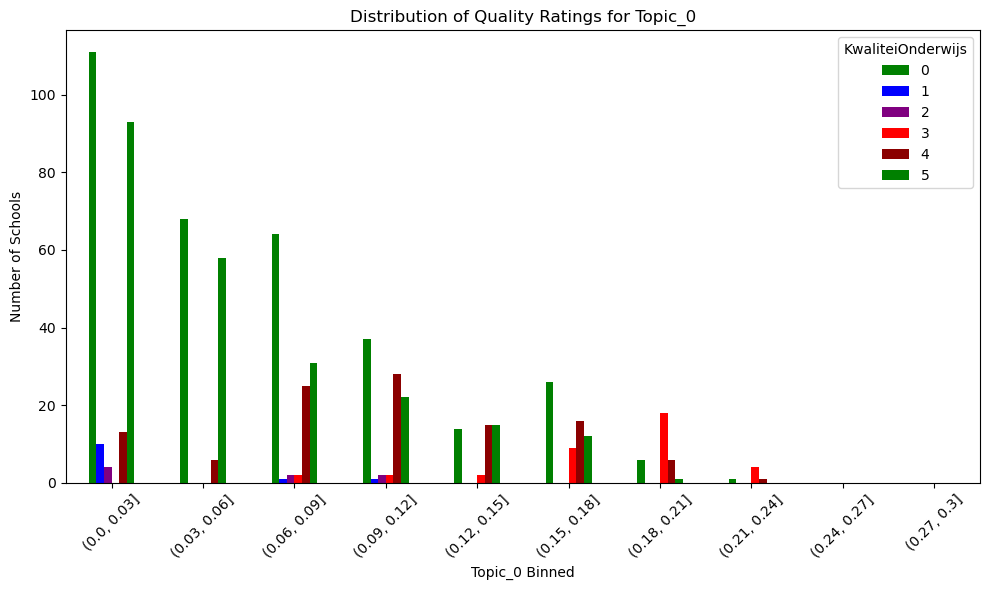

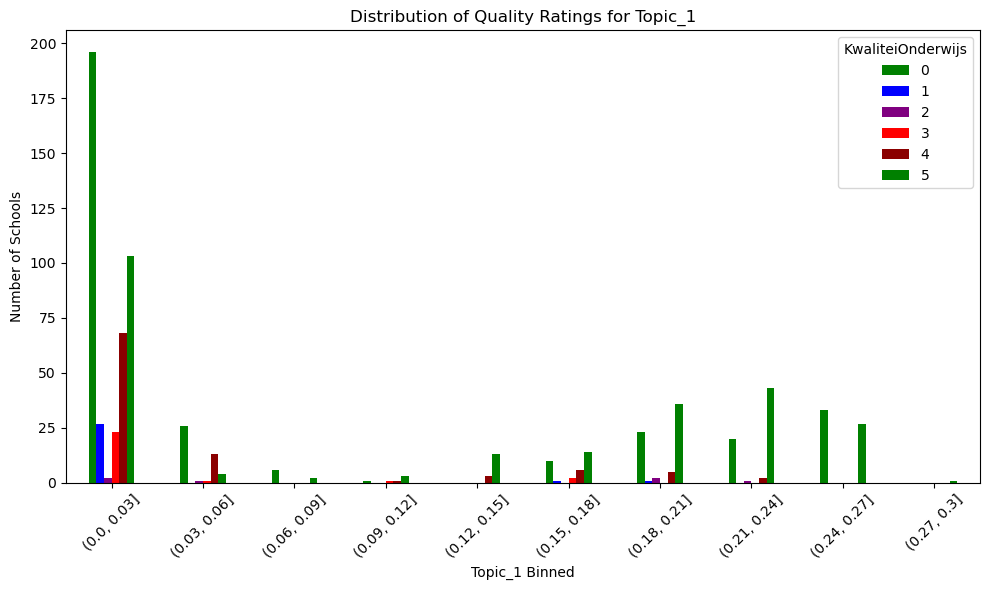

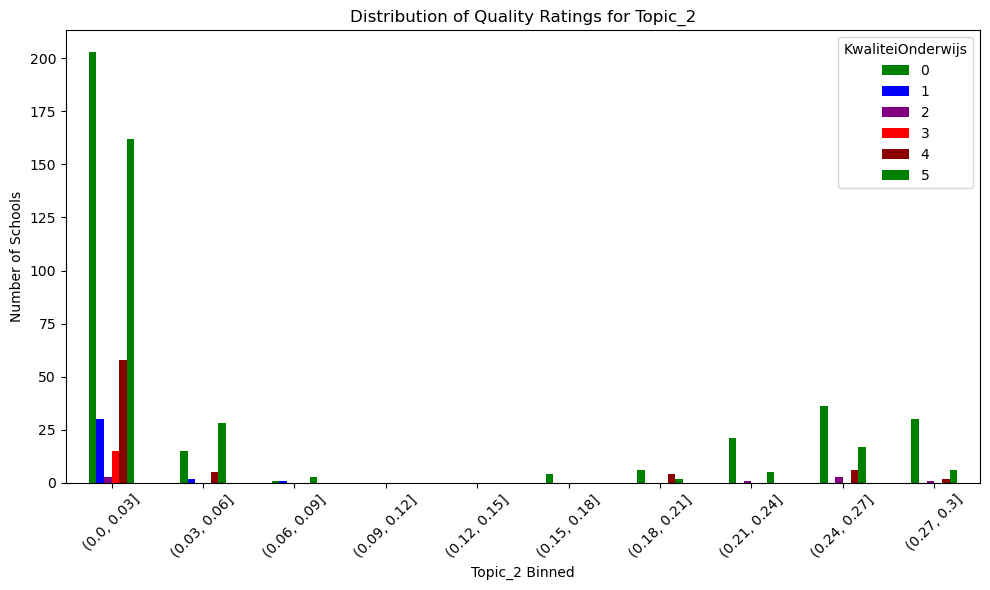

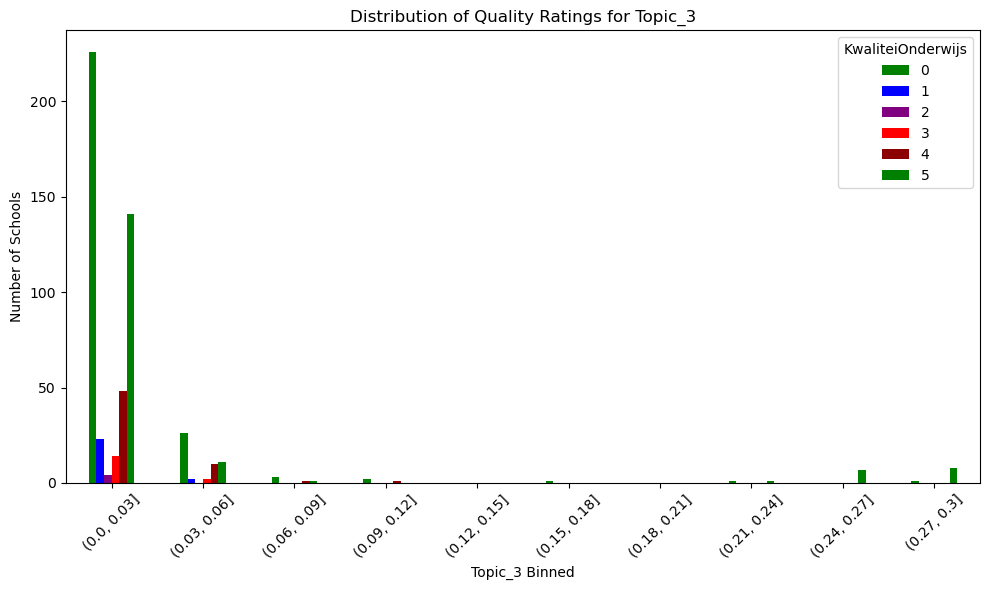

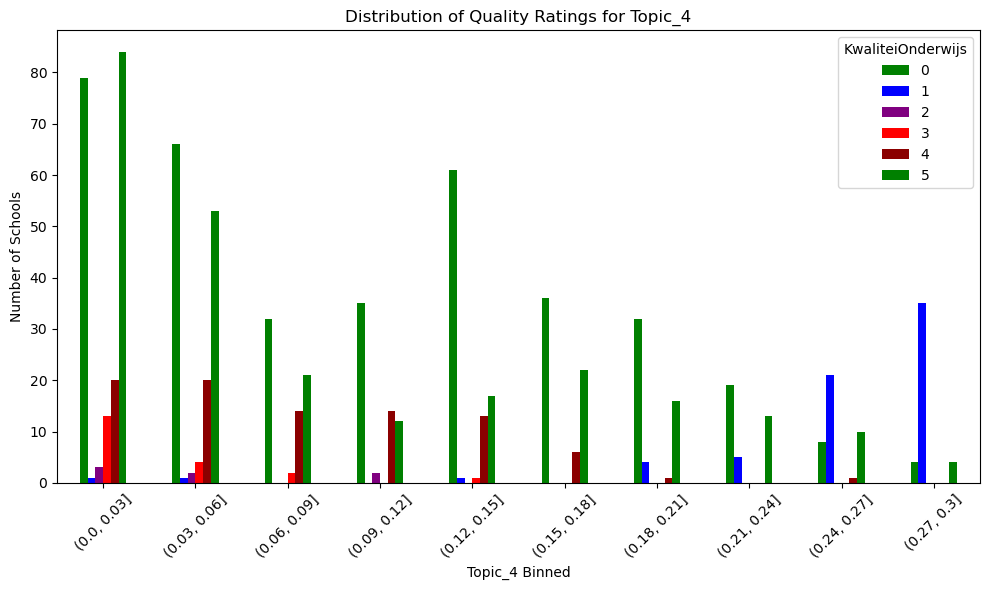

In [26]:


def plot_quality_distribution_per_topic(topic_df, topic_column, bins):
    # Bin the topic contributions
    topic_df[f'{topic_column}_binned'] = pd.cut(topic_df[topic_column], bins=bins)
    
    # Group by the binned topic contributions and count quality ratings
    topic_class_distribution = topic_df.groupby(f'{topic_column}_binned')['KwaliteiOnderwijs'].value_counts().unstack().fillna(0)
    
    # Define custom colors for each quality rating
    colors = {
        0: 'green',       # Voldoende
        1: 'blue',        # Goed
        2: 'purple',      # Basistoezicht
        3: 'red',         # Onvoldoende
        4: 'darkred'      # Zeer zwak
    }
    
    # Create a custom color map for the plot
    color_list = [colors.get(i) for i in range(5)]
    
    # Plot the distribution of classes per topic using a grouped bar chart
    topic_class_distribution.plot(kind='bar', figsize=(10, 6), color=color_list)
    plt.title(f'Distribution of Quality Ratings for {topic_column}')
    plt.xlabel(f'{topic_column} Binned')
    plt.ylabel('Number of Schools')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Plot for each topic
for i in range(0, num_topics ):
    start = 0.0
    end = 0.3
    num_bins = 10
# Create the bins
    bins = np.linspace(start, end, num_bins + 1)
    plot_quality_distribution_per_topic(topic_df, f'Topic_{i}', bins)



# load Schools quality scores

In [10]:
excel_file_path = '/Users/sanam/Downloads/schoolweging_2020-2023.xlsx'
table3 = pd.read_excel(excel_file_path, sheet_name='Tabel 3')

# clean data


In [11]:
header_row = 2 


table3.columns = table3.iloc[header_row]
table3 = table3.drop([0, 1, 2, 3])
table3.columns = table3.columns.str.strip()  # Standardize column names

print("\nColumns after setting headers and dropping initial rows:")
print(table3.columns)



Columns after setting headers and dropping initial rows:
Index(['BRIN', 'Vestiging', 'Nummer bevoegd gezag', 'Schoolweging',
       'Spreiding', 'Aantal leerlingen'],
      dtype='object', name=2)


In [29]:
relevant_columns = ['BRIN', 'Schoolweging', 'Spreiding', 'Aantal leerlingen']
try:
    table3 = table3[relevant_columns]
except KeyError as e:
    print(f"\nKeyError: {e}")

table3 = table3.dropna(subset=relevant_columns)
table3 = table3.reset_index(drop=True)


In [13]:
table3['Schoolweging'] = pd.to_numeric(table3['Schoolweging'], errors='coerce')
table3['Spreiding'] = pd.to_numeric(table3['Spreiding'], errors='coerce')
table3['Aantal leerlingen'] = pd.to_numeric(table3['Aantal leerlingen'], errors='coerce')

# Standardize the BRIN column
table3['BRIN'] = table3['BRIN'].str.strip().str.upper()

csv_file_path = 'table3_cleaned.csv'
table3.to_csv(csv_file_path, index=False)

print(f"Table 3 data has been successfully saved to {csv_file_path}")

Table 3 data has been successfully saved to table3_cleaned.csv


In [31]:
table3_cleaned_path = 'table3_cleaned.csv'
table3_cleaned = pd.read_csv(table3_cleaned_path)
print(len(table3_cleaned['BRIN']))
# Load the topic data from the CSV file
# topic_data_path = 'topicperschool.csv'
# topic_data = pd.read_csv(topic_data_path)
# print(topic_data['Brin'])
print(len(topic_df['Brin']))
topic_df = topic_df.rename(columns={'Brin': 'BRIN'})
print(len(topic_df['BRIN']))
# topic_data



6153
1012
1012


# MERGE dataframes 

In [34]:
table3_cleaned['BRIN'] = table3_cleaned['BRIN'].str.strip().str.upper()
topic_df['BRIN'] = topic_df['BRIN'].str.strip().str.upper()


merged_df = pd.merge(table3_cleaned, topic_df[['BRIN', 'KwaliteiOnderwijs','Topic_0','Topic_1','Topic_2','Topic_3','Topic_4']], on='BRIN', how='inner')
merged_df = merged_df.drop(columns=['Spreiding','Aantal leerlingen'])

merged_df.to_csv('TL3mergeTopic.csv')
# Display the merged dataframe

# Removing outlires

In [16]:

target = 'Schoolweging'

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = merged_df[target].quantile(0.25)
Q3 = merged_df[target].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
merged_df_no_outliers = merged_df[(merged_df[target] >= lower_bound) & (merged_df[target] <= upper_bound)]
merged_df.to_excel("merged.xlsx")



# spliting data 

In [17]:
overall_mean = merged_df['Schoolweging'].mean()
X_train, X_test, y_train, y_test = train_test_split(
    merged_df[['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4']],  
    merged_df['Schoolweging'], 
    test_size=0.2,  
    random_state=42,  
    stratify=(merged_df['Schoolweging'] > overall_mean)
)

# linear regression 

selected_features : [False False  True  True False]
selected_features : Index(['Topic_2', 'Topic_3'], dtype='object')
Mean Squared Error train: 3.5707
Mean Squared Error test: 3.9465
Most influential topic dimensions on Schoolweging:
Topic_2    51.960257
Topic_3    12.621491
dtype: float64


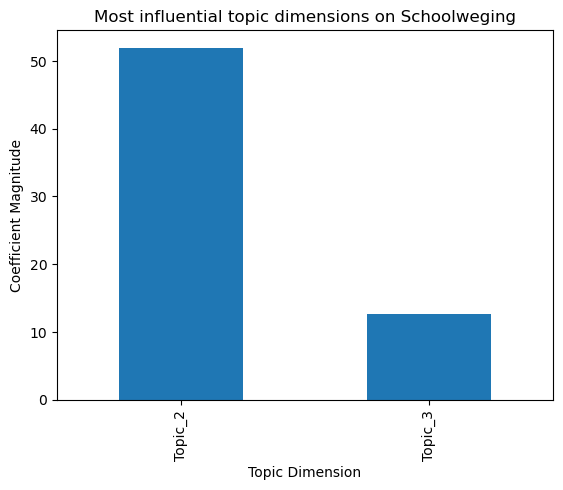

     Actual  Predicted
143   29.52  30.931144
807   26.33  31.153538
582   30.74  30.937180
61    29.05  30.083026
163   31.54  30.000885
30.975575757575754
30.974121212121208


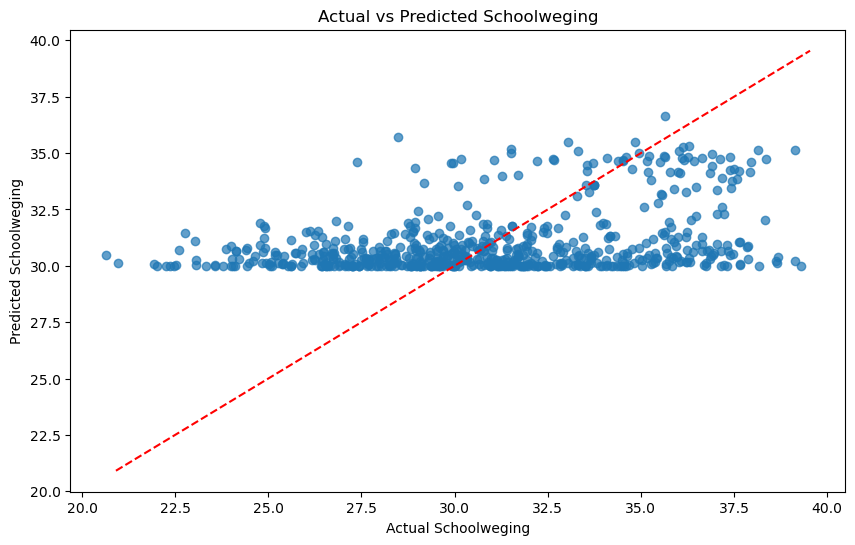

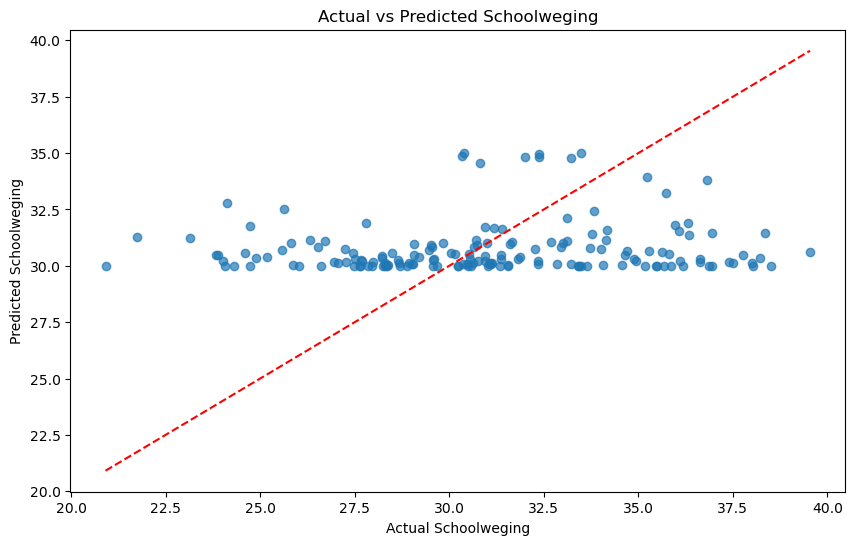

In [18]:

model = LinearRegression()
sfs = SequentialFeatureSelector(model, direction='forward', n_features_to_select='auto')
sfs.fit(X_train, y_train)

# Get selected features
print("selected_features :" ,sfs.get_support())
selected_features = X_train.columns[sfs.get_support()]
print("selected_features :" ,selected_features)
# Fit model with selected features
model.fit(X_train[selected_features], y_train)

y_pred_train = model.predict(X_train[selected_features])
y_pred_test = model.predict(X_test[selected_features])
# Coefficients

mse = mean_squared_error(y_train, y_pred_train,squared=False)
print(f'Mean Squared Error train: {mse:.4f}')

mse = mean_squared_error(y_test, y_pred_test,squared=False)
print(f'Mean Squared Error test: {mse:.4f}')

# Coefficients
coefficients = pd.Series(model.coef_, index=selected_features)
most_influential = coefficients.sort_values(ascending=False)

# Display the most influential topics
print("Most influential topic dimensions on Schoolweging:")
print(most_influential)

# Plot coefficients
most_influential.plot(kind='bar', title='Most influential topic dimensions on Schoolweging')
plt.xlabel('Topic Dimension')
plt.ylabel('Coefficient Magnitude')
plt.show()
# Compare actual vs. predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
print(results_df.head())

print(y_test.mean())
print(y_pred_train.mean())
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.7)
plt.title('Actual vs Predicted Schoolweging')
plt.xlabel('Actual Schoolweging')
plt.ylabel('Predicted Schoolweging')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.title('Actual vs Predicted Schoolweging')
plt.xlabel('Actual Schoolweging')
plt.ylabel('Predicted Schoolweging')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()



# Statistical properties of data 

count    825.000000
mean      30.974412
std        3.845600
min       20.630000
25%       28.300000
50%       30.800000
75%       33.830000
max       39.540000
Name: Schoolweging, dtype: float64
Skewness: -0.031902892698492995
Kurtosis: -0.6184007804795857
0.25    28.30
0.50    30.80
0.75    33.83
Name: Schoolweging, dtype: float64


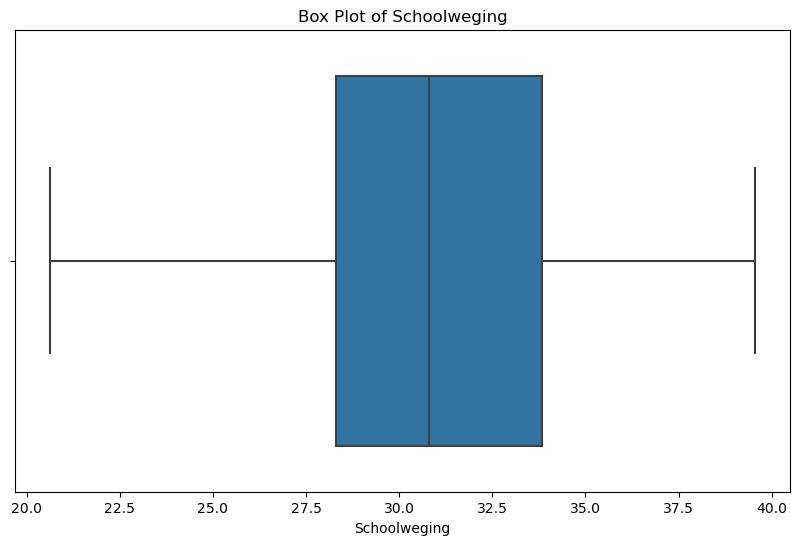

/var/folders/35/m9jg2n791l542p5mnwq18ldw0000gn/T/ipykernel_92397/178623473.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['Schoolweging'], shade=True)


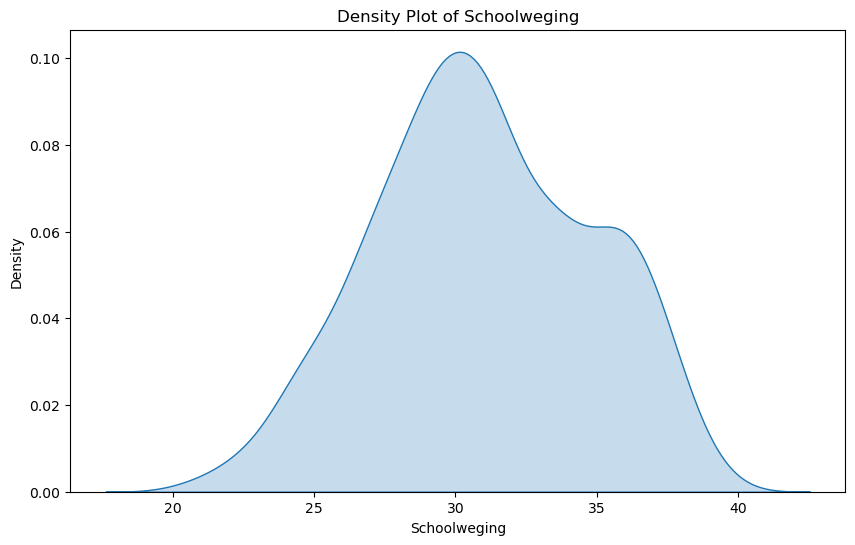

count    660.000000
mean      30.974121
std        3.834415
min       20.630000
25%       28.292500
50%       30.795000
75%       33.860000
max       39.290000
Name: Schoolweging, dtype: float64
count    165.000000
mean      30.975576
std        3.901793
min       20.910000
25%       28.300000
50%       30.820000
75%       33.770000
max       39.540000
Name: Schoolweging, dtype: float64


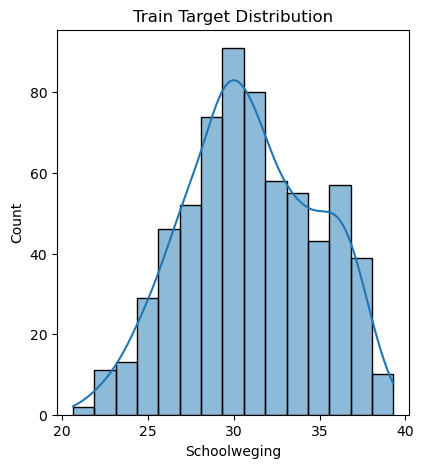

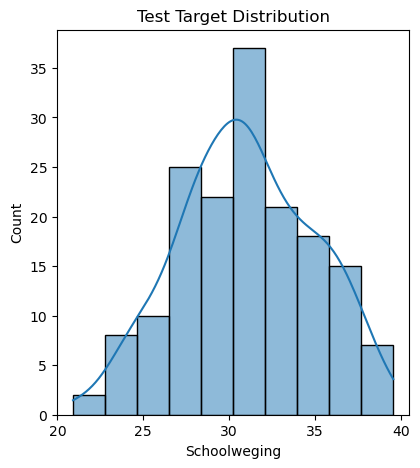

In [19]:
print(merged_df['Schoolweging'].describe())

# Skewness and Kurtosis
print(f"Skewness: {merged_df['Schoolweging'].skew()}")
print(f"Kurtosis: {merged_df['Schoolweging'].kurt()}")

# Quantile Analysis
quantiles = merged_df['Schoolweging'].quantile([0.25, 0.5, 0.75])
print(quantiles)

# Box Plot for outlier detection
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['Schoolweging'])
plt.title('Box Plot of Schoolweging')
plt.show()

# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(merged_df['Schoolweging'], shade=True)
plt.title('Density Plot of Schoolweging')
plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title('Train Target Distribution')
print(y_train.describe())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_test, kde=True)
plt.title('Test Target Distribution')
print(y_test.describe())



In [20]:

X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit the regression model
model = sm.OLS(y_train, X_train_const).fit()
coefficients = pd.Series(model.params, index=X_train_const.columns)
p_values = pd.Series(model.pvalues, index=X_train_const.columns)

# Display the p-values
print("P-values for each variable:")
print(p_values)
print("Coefficient for each variable:")
print(coefficients)



significant_vars = p_values[p_values < 0.05].index[1::]
print(significant_vars)
# Sort the significant coefficients in descending order
most_influential = coefficients[significant_vars].sort_values(ascending=False)

print(model.summary())
# Display the most influential topics
print("Most influential topics:")
print(most_influential)


P-values for each variable:
const      7.796651e-51
Topic_0    2.246356e-01
Topic_1    4.062829e-01
Topic_2    6.700061e-06
Topic_3    2.826370e-04
Topic_4    3.388131e-01
dtype: float64
Coefficient for each variable:
const      28.242432
Topic_0    10.462314
Topic_1     4.952428
Topic_2    56.739200
Topic_3    17.258620
Topic_4     6.096660
dtype: float64
Index(['Topic_2', 'Topic_3'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:           Schoolweging   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     20.33
Date:                Sun, 14 Jul 2024   Prob (F-statistic):           6.90e-19
Time:                        21:48:37   Log-Likelihood:                -1775.4
No. Observations:                 660   AIC:                             3563.
Df Residuals:                     654   BI

# Residuals

30.974121212121208
30.974121212121208


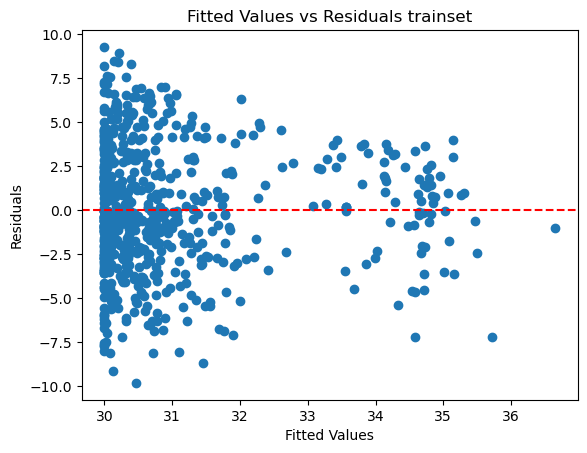

In [21]:

residuals = y_train - y_pred_train
print(y_train.mean())
print(y_pred_train.mean())
plt.scatter(y_pred_train, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals trainset')
plt.show()

30.975575757575754
30.76547531879876


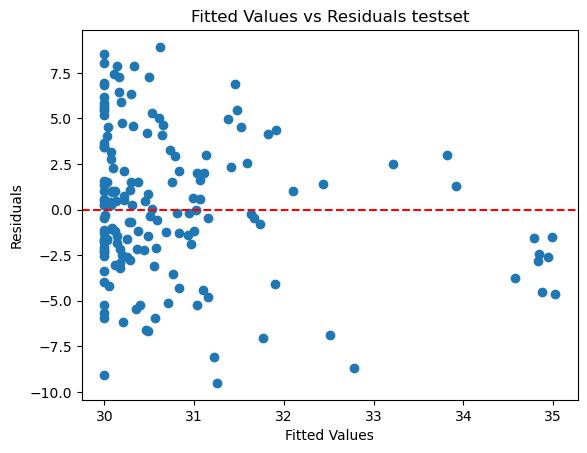

In [22]:

residuals = y_test - y_pred_test
print(y_test.mean())
print(y_pred_test.mean())
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals testset')
plt.show()